# Magnetic Range of Influence (MRoI)
This routine generates a map of the Magnetic Range of Influence (MRoI) for a synoptic chart of radial magnetic flux density input in a sine-latitude coordinate system.

For more details see the paper by McIntosh insertyearhere.

Begin by importing the relevant python libraries

In [12]:
import matplotlib
from matplotlib import pylab, mlab, pyplot
plt = pyplot
import numpy as np
import sunpy.io

To simplify the computation time (look into embarassingly simple parallelization here...), rebin the input magnetograms to something more reasonable.

In [5]:
f = sunpy.io.read_file('hmi.synoptic_mr_polfil_720s.2193.Mr_polfil.fits')
br0 = f[1].data

import scipy.ndimage
br = scipy.ndimage.zoom(br0, 0.05)

Define a few useful functions to move forward.

In [6]:
def gen_mroi(br):

    # Define the coordinate system
    # CL - Generate this from the FITS file...
    lats = np.linspace(-1, 1, br.shape[0])
    lons = np.linspace(0, 2*np.pi, br.shape[1])

    # Compute an empty array to store MRoI values
    mroi = np.zeros(br.shape)

    # Move along through the coordinates and compute MRoI
    # CL - Note that for the moment, the corrected polar field maps result in... a difficult computational time, as the routine needs to search fairly far out to balance the unipolar field.
    # CL - Think about where the speed bottleneck might be in this code... if it's something that can be simplified.
    # CL - This could also be the perfect testbed for parallelization of Python code, given that this problem is embarassingly simple to parallelize
    pbar = tqdm(total=lats.shape[0]*lons.shape[0])
    for ilat in np.arange(lats.shape[0]):
        for ilon in np.arange(lons.shape[0]):

            # Compute a great cicle distance map
            #   and distance list
            gcmap = gen_gcmap(lats[ilat], lons[ilon], lats, lons)
            dvals = np.unique(gcmap)

            # Integrate flux outward in distance until neutralized
            oflux = br[ilat, ilon]
            iflux = oflux
            r0 = 0
            for d in dvals[1:]:
                wdr = where(np.logical_and((gcmap > r0),(gcmap <= d)))
                iflux += br[wdr].sum()
                r0 = d      # Distance assigned post balance
                if ( np.sign(iflux) != np.sign(oflux) ): break

            # Assign this computed value of MRoI
            mroi[ilat, ilon] = r0

            # For now, save this at every step to preview output
            np.save('mroi.npy', mroi)

            # Update the progress bar
            pbar.update(1)

    pbar.close()
    return mroi

In [7]:
def gen_gcmap(lat, lon, lats, lons):
    '''
    Generates a great circle distance map for a specified coordiate and sine-latitude map
    Input latitude is specified in sine-latitude
    '''
    # Define constants and coordinates
    rsun = 6.957e10 #cm
    mlons, mlats = np.meshgrid(lons, lats)

    # Generate the great circle distance map
    gcmap = rsun * np.arccos(mlats*lat + np.cos(np.arcsin(mlats))*np.cos(np.arcsin(lat))*np.cos(np.abs(mlons-lon)))
 
    return gcmap

Generate the MRoI map. For now, just pull the pre-computed result from a numpy array.

In [9]:
mroi = np.load('mroi.npy')

Plot the results.

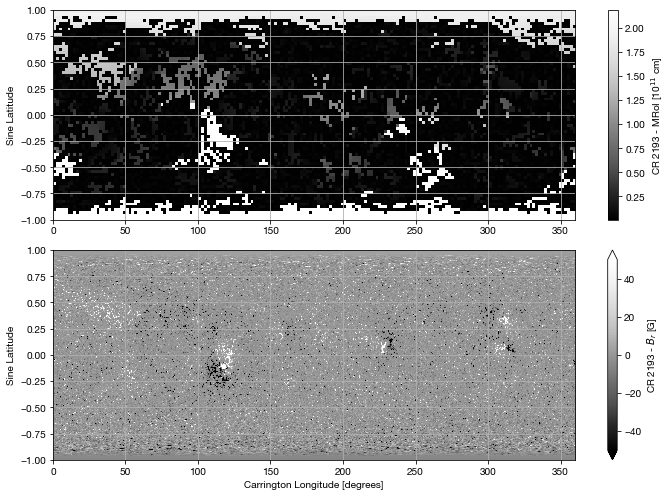

In [21]:
f, (ax1,ax2) = plt.subplots(2, figsize=[10,7])
im1 = ax1.imshow(mroi/1e11, extent=[0,360,-1,1], aspect='auto')
cb1 = plt.colorbar(im1, ax=ax1, label='CR 2193 - MRoI [10$^{11}$ cm]')
ax1.set_ylabel('Sine Latitude')
im2 = ax2.imshow(br0, extent=[0,360,-1,1], aspect='auto', vmin=-50, vmax=50, cmap='Greys_r')
cb2 = plt.colorbar(im2, ax=ax2, label='CR 2193 - $B_r$ [G]', extend='both')
ax2.set_xlabel('Carrington Longitude [degrees]')
ax2.set_ylabel('Sine Latitude')
ax1.grid()
ax2.grid()
plt.tight_layout()